<a href="https://colab.research.google.com/github/i-ganza007/Kuiper_Summative/blob/main/training/A2C/A2C_value_focused.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q gymnasium pygame numpy stable-baselines3[extra] tensorboard tqdm seaborn ipywidgets tensorflow


In [ ]:
import gymnasium as gym
import numpy as np
import pygame
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

base_dir = "/kaggle/working" if 'kaggle' in str(os.uname()).lower() else "."
os.makedirs(f"{base_dir}/models/a2c", exist_ok=True)
os.makedirs(f"{base_dir}/results/a2c", exist_ok=True)
os.makedirs(f"{base_dir}/logs/a2c", exist_ok=True)
os.makedirs(f"{base_dir}/tensorboard", exist_ok=True)
print("Setup complete!")

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Setup complete!


In [ ]:
class AdvancedMetricsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.ep_rewards = []
        self.ep_lengths = []
        self.timesteps = []
        self.successes = []

    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            for i, done in enumerate(self.locals["dones"]):
                if done and "episode" in self.locals["infos"][i]:
                    info = self.locals["infos"][i]["episode"]
                    self.ep_rewards.append(info["r"])
                    self.ep_lengths.append(info["l"])
                    self.timesteps.append(self.num_timesteps)
                    self.successes.append(info["r"] >= 100)
        return True

class MissionEnvironment(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}

    def __init__(self, grid_size=10, num_missions=3, render_mode=None):
        super().__init__()
        self.grid_size = grid_size
        self.num_missions = num_missions
        self.render_mode = render_mode

        self.action_space = spaces.Discrete(5)

        obs_size = 4 + (num_missions * 3)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0] + [0, -grid_size, -grid_size] * num_missions, dtype=np.float32),
            high=np.array([grid_size, grid_size, 200, num_missions] + [np.sqrt(2*grid_size**2), grid_size, grid_size] * num_missions, dtype=np.float32),
            dtype=np.float32
        )

        self.agent_pos = None
        self.missions = None
        self.completed_missions = None
        self.fuel = 200
        self.max_fuel = 200
        self.steps = 0
        self.max_steps = 500
        self.window = None
        self.clock = None


    def reset(self, seed=None):
        super().reset(seed=seed)
        self.agent_pos = np.array(
            [self.np_random.integers(0, self.grid_size),
             self.np_random.integers(0, self.grid_size)],
            dtype=np.int32
        )
        self.missions = []
        for _ in range(self.num_missions):
            while True:
                mission = np.array(
                    [self.np_random.integers(0, self.grid_size),
                     self.np_random.integers(0, self.grid_size)],
                    dtype=np.int32
                )
                if not np.array_equal(mission, self.agent_pos) and \
                   not any(np.array_equal(mission, m) for m in self.missions):
                    self.missions.append(mission)
                    break
        self.completed_missions = np.zeros(self.num_missions, dtype=bool)
        self.fuel = self.max_fuel
        self.steps = 0
        return self._get_observation(), {}

    def _get_observation(self):
        obs = np.zeros(4 + self.num_missions * 3, dtype=np.float32)
        obs[0] = float(self.agent_pos[0])
        obs[1] = float(self.agent_pos[1])
        obs[2] = float(self.fuel)
        obs[3] = float(np.sum(self.completed_missions))

        mission_idx = 0
        for i in range(self.num_missions):
            if not self.completed_missions[i]:
                dx = float(self.missions[i][0] - self.agent_pos[0])
                dy = float(self.missions[i][1] - self.agent_pos[1])
                dist = np.sqrt(dx**2 + dy**2)
                obs[4 + mission_idx*3] = dist
                obs[4 + mission_idx*3 + 1] = dx
                obs[4 + mission_idx*3 + 2] = dy
            else:
                obs[4 + mission_idx*3] = 0.0
                obs[4 + mission_idx*3 + 1] = 0.0
                obs[4 + mission_idx*3 + 2] = 0.0
            mission_idx += 1

        return obs

    def step(self, action):
        self.steps += 1
        reward = -0.1
        terminated = False
        truncated = self.steps >= self.max_steps

        if action < 4:
            if self.fuel > 0:
                deltas = [(-1, 0), (1, 0), (0, -1), (0, 1)][action]
                new_pos = self.agent_pos + np.array(deltas)

                if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
                    self.agent_pos = new_pos
                    self.fuel -= 1

                    active_mission_indices = [i for i in range(self.num_missions)
                                            if not self.completed_missions[i]]
                    if active_mission_indices:
                        distances = [np.linalg.norm(self.agent_pos - self.missions[i])
                                   for i in active_mission_indices]
                        min_dist = np.min(distances)
                        reward += 2.0 / (1.0 + min_dist)
                else:
                    reward -= 0.2
            else:
                reward -= 0.1

        elif action == 4:
            mission_completed = False
            for i, mission in enumerate(self.missions):
                if not self.completed_missions[i] and np.array_equal(self.agent_pos, mission):
                    self.completed_missions[i] = True
                    reward += 200.0
                    mission_completed = True
                    self.fuel = min(self.max_fuel, self.fuel + 30)
                    break

            if not mission_completed:
                reward -= 0.5

        completed_count = np.sum(self.completed_missions)
        if completed_count == self.num_missions:
            reward += 500.0
            reward += self.fuel * 0.5
            terminated = True

        if self.fuel <= 0 and not terminated:
            reward -= 10.0
            terminated = True

        if truncated and not terminated:
            reward -= 5.0

        return self._get_observation(), reward, terminated, truncated, {}

    def render(self):
        if self.render_mode is None:
            return
        if self.window is None and self.render_mode == "human":
            import pygame
            pygame.init()
            self.window = pygame.display.set_mode((600, 600))
            self.clock = pygame.time.Clock()

        import pygame
        canvas = pygame.Surface((600, 600))
        canvas.fill((255, 255, 255))
        pix = 600 / self.grid_size

        for i, m in enumerate(self.missions):
            color = (100, 200, 100) if self.completed_missions[i] else (200, 100, 100)
            pygame.draw.rect(canvas, color, (m[0]*pix, m[1]*pix, pix, pix))

        pygame.draw.circle(canvas, (0, 0, 255),
                          ((self.agent_pos[0]+0.5)*pix, (self.agent_pos[1]+0.5)*pix),
                          pix/3)

        for x in range(self.grid_size + 1):
            pygame.draw.line(canvas, (200, 200, 200), (x*pix, 0), (x*pix, 600))
            pygame.draw.line(canvas, (200, 200, 200), (0, x*pix), (600, x*pix))

        if self.render_mode == "human":
            self.window.blit(canvas, (0, 0))
            pygame.display.flip()
            self.clock.tick(30)

    def close(self):
        if self.window:
            import pygame
            pygame.quit()
            self.window = None

gym.register(id="MissionEnv-v0", entry_point="__main__:MissionEnvironment",
             max_episode_steps=500)
print("MissionEnv-v0 registered!")

MissionEnv-v0 registered!


In [ ]:
A2C_CONFIGS = {
    "baseline": {
        "learning_rate": 7e-4,
        "n_steps": 5,
        "gamma": 0.99,
        "gae_lambda": 1.0,
        "ent_coef": 0.0,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": False
    },

    "high_exploration": {
        "learning_rate": 2e-4,
        "n_steps": 128,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "ent_coef": 0.15,
        "vf_coef": 0.5,
        "max_grad_norm": 0.8,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": True
    },

    "long_horizon": {
        "learning_rate": 1e-4,
        "n_steps": 512,
        "gamma": 0.995,
        "gae_lambda": 0.98,
        "ent_coef": 0.02,
        "vf_coef": 0.5,
        "max_grad_norm": 1.0,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": True
    },

    "conservative": {
        "learning_rate": 5e-5,
        "n_steps": 64,
        "gamma": 0.99,
        "gae_lambda": 0.9,
        "ent_coef": 0.01,
        "vf_coef": 0.8,
        "max_grad_norm": 0.3,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": True
    },

    "fast_learning": {
        "learning_rate": 1e-3,
        "n_steps": 32,
        "gamma": 0.95,
        "gae_lambda": 0.9,
        "ent_coef": 0.08,
        "vf_coef": 0.3,
        "max_grad_norm": 1.2,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": False
    },

    "balanced": {
        "learning_rate": 3e-4,
        "n_steps": 256,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "ent_coef": 0.06,
        "vf_coef": 0.5,
        "max_grad_norm": 0.8,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": True
    },

    "value_focused": {
        "learning_rate": 2e-4,
        "n_steps": 128,
        "gamma": 0.99,
        "gae_lambda": 0.92,
        "ent_coef": 0.01,
        "vf_coef": 1.0,
        "max_grad_norm": 0.6,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": True
    },

    "policy_focused": {
        "learning_rate": 4e-4,
        "n_steps": 192,
        "gamma": 0.98,
        "gae_lambda": 0.97,
        "ent_coef": 0.12,
        "vf_coef": 0.2,
        "max_grad_norm": 1.0,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": False
    },

    "adaptive": {
        "learning_rate": 6e-4,
        "n_steps": 384,
        "gamma": 0.992,
        "gae_lambda": 0.96,
        "ent_coef": 0.04,
        "vf_coef": 0.6,
        "max_grad_norm": 0.7,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": True
    },

    "aggressive": {
        "learning_rate": 8e-4,
        "n_steps": 16,
        "gamma": 0.9,
        "gae_lambda": 0.8,
        "ent_coef": 0.2,
        "vf_coef": 0.1,
        "max_grad_norm": 2.0,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": False
    },

    "improved_v2": {
        "learning_rate": 3e-4,
        "n_steps": 256,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "ent_coef": 0.1,
        "vf_coef": 0.5,
        "max_grad_norm": 0.8,
        "rms_prop_eps": 1e-5,
        "use_rms_prop": True,
        "normalize_advantage": True
    }
}

In [ ]:
import torch
import torch.nn as nn
def train_a2c(config_name: str, total_timesteps=500_000, n_envs=8):
    config = A2C_CONFIGS[config_name]
    print(f"\n{'='*80}\nTRAINING A2C → {config_name.upper()}\n{'='*80}")

    env = make_vec_env("MissionEnv-v0", n_envs=n_envs, wrapper_class=Monitor)
    eval_env = Monitor(gym.make("MissionEnv-v0"))

    metrics_cb = AdvancedMetricsCallback()
    eval_cb = EvalCallback(eval_env, eval_freq=10000, n_eval_episodes=20, deterministic=True, verbose=0)

    model = A2C("MlpPolicy", env,
                policy_kwargs=dict(
                    net_arch=[256, 256],
                    activation_fn=torch.nn.ReLU
                ),
                tensorboard_log=f"{base_dir}/tensorboard",
                verbose=1,
                **config)

    start = time.time()
    model.learn(total_timesteps=total_timesteps, callback=[eval_cb, metrics_cb], progress_bar=True)
    train_time = time.time() - start

    rewards = np.array(metrics_cb.ep_rewards)
    if len(rewards) > 50:
        rolling = np.convolve(rewards, np.ones(20)/20, mode='valid')
        threshold = np.percentile(rewards, 90)
        conv_idx = next((i for i, r in enumerate(rolling) if np.all(rolling[i:i+20] >= threshold)), None)
        convergence_ts = metrics_cb.timesteps[conv_idx + 19] if conv_idx is not None else None
    else:
        convergence_ts = None

    model_path = f"{base_dir}/models/a2c/a2c_{config_name}.zip"
    model.save(model_path)
    print(f"✓ MODEL SAVED: {model_path}")

    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50, deterministic=True)
    success_rate = np.mean(metrics_cb.successes[-100:]) * 100 if metrics_cb.successes else 0

    results = {
        "config": config_name,
        "mean_reward": round(float(mean_reward), 2),
        "std_reward": round(float(std_reward), 2),
        "avg_steps_per_episode": round(np.mean(metrics_cb.ep_lengths[-50:]), 1),
        "success_rate_%": round(success_rate, 1),
        "convergence_timestep": int(convergence_ts) if convergence_ts else None,
        "train_time_min": round(train_time/60, 2),
        "total_timesteps": total_timesteps,
        "model_path": model_path
    }

    with open(f"{base_dir}/results/a2c/{config_name}_results.json", "w") as f:
        json.dump({**results, "rewards_history": metrics_cb.ep_rewards[-500:],
                   "lengths_history": metrics_cb.ep_lengths[-500:]}, f, indent=4)

    print(f"Reward: {mean_reward:+.1f} ± {std_reward:.1f} | Steps/Episode: {results['avg_steps_per_episode']}")
    print(f"Success: {success_rate:.1f}% | Convergence: {convergence_ts or 'N/A'} steps")
    env.close(); eval_env.close()
    return results, metrics_cb

train_a2c("value_focused", total_timesteps=500_000, n_envs=8)


TRAINING A2C → VALUE_FOCUSED
Using cuda device
Logging to ./tensorboard/A2C_15


Output()

------------------------------------
| eval/                 |          |
|    mean_ep_length     | 500      |
|    mean_reward        | -151     |
| time/                 |          |
|    total_timesteps    | 80000    |
| train/                |          |
|    entropy_loss       | -1.09    |
|    explained_variance | 0.206    |
|    learning_rate      | 0.0002   |
|    n_updates          | 78       |
|    policy_loss        | 0.0774   |
|    value_loss         | 252      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 250      |
|    ep_rew_mean        | 112      |
| time/                 |          |
|    fps                | 3298     |
|    iterations         | 100      |
|    time_elapsed       | 31       |
|    total_timesteps    | 102400   |
| train/                |          |
|    entropy_loss       | -1.12    |
|    explained_variance | 0.944    |
|    learning_rate      | 0.0002   |
|

✓ MODEL SAVED: ./models/a2c/a2c_value_focused.zip
Reward: -305.0 ± 0.0 | Steps/Episode: 357.3
Success: 82.0% | Convergence: 325576 steps


({'config': 'value_focused',
  'mean_reward': -305.0,
  'std_reward': 0.0,
  'avg_steps_per_episode': 357.3,
  'success_rate_%': 82.0,
  'convergence_timestep': 325576,
  'train_time_min': 2.59,
  'total_timesteps': 500000,
  'model_path': './models/a2c/a2c_value_focused.zip'},
 <__main__.AdvancedMetricsCallback at 0x7e98122024d0>)

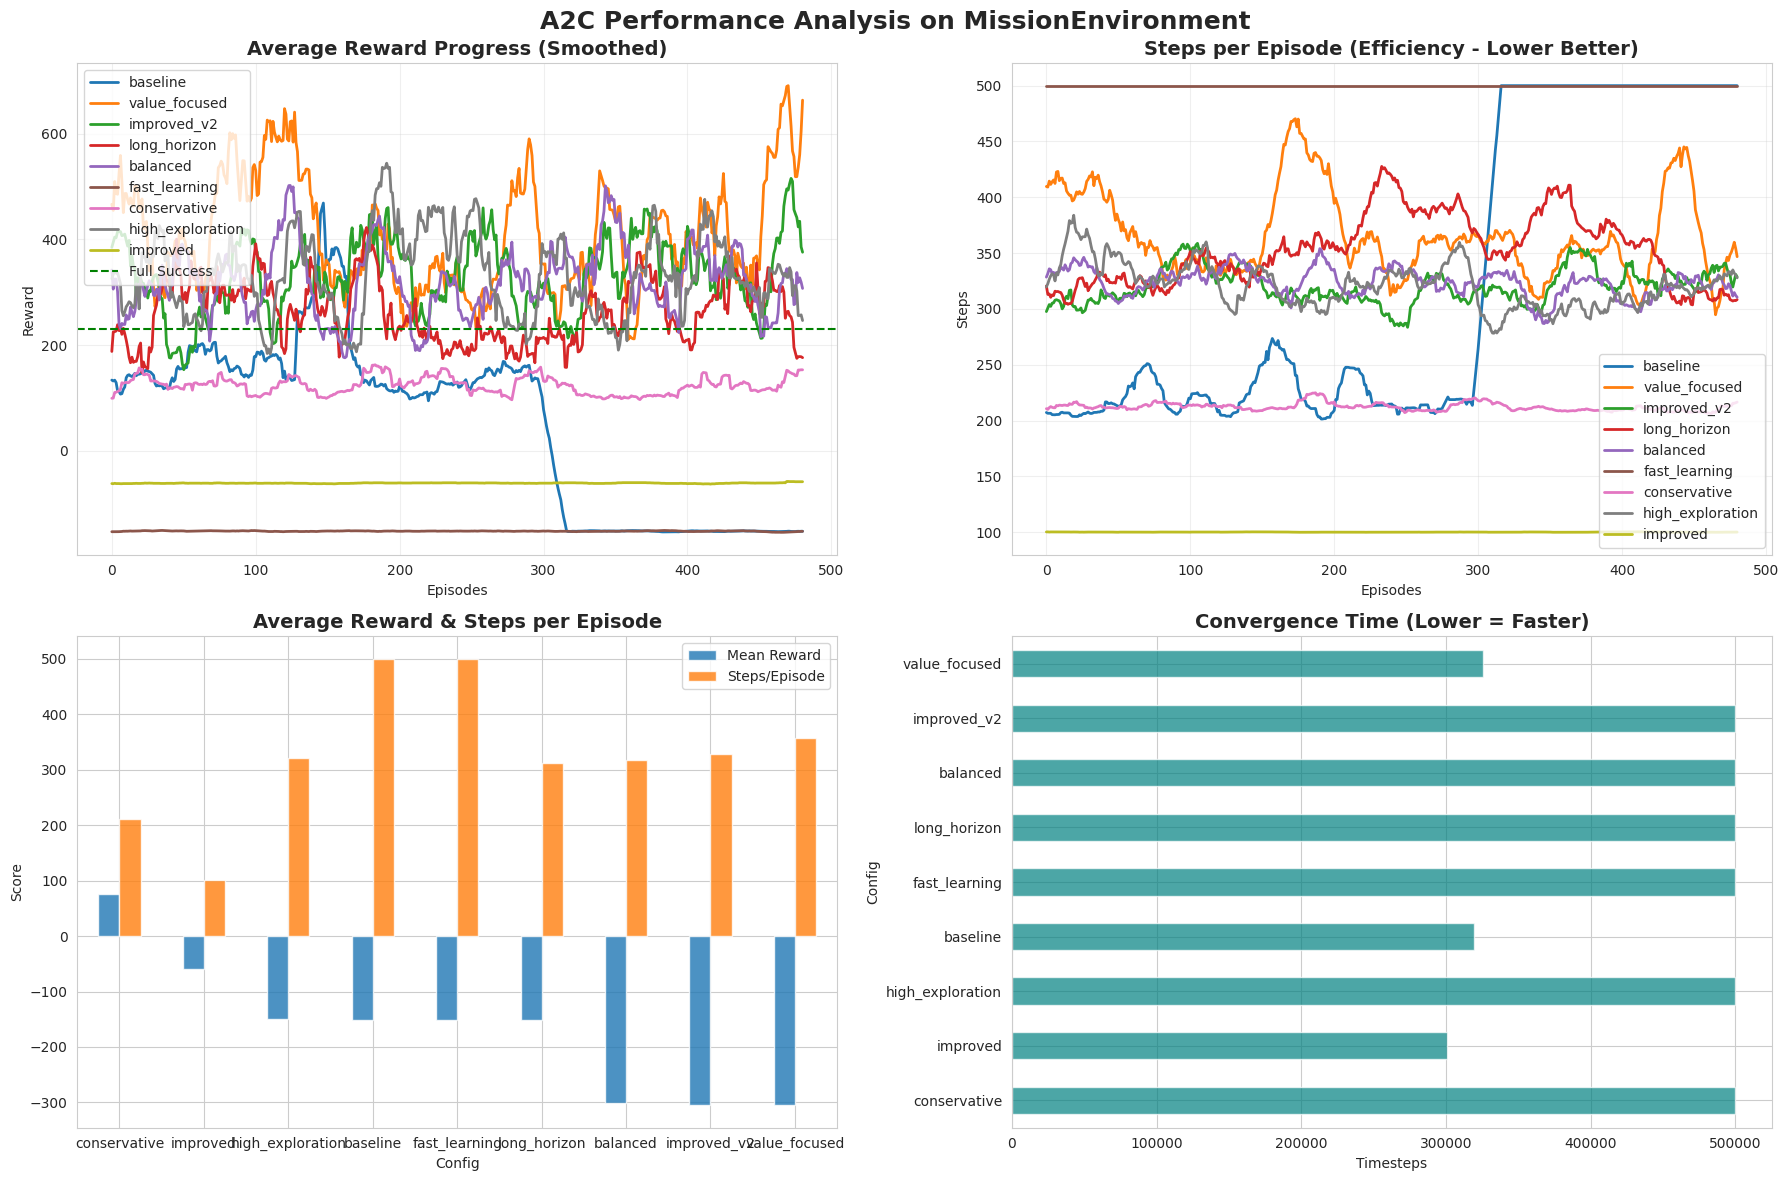

In [ ]:
import pandas as pd
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

all_results = []
for f in os.listdir(f"{base_dir}/results/a2c"):
    if f.endswith(".json"):
        with open(f"{base_dir}/results/a2c/{f}") as j:
            data = json.load(j)
            all_results.append({
                "Config": data["config"],
                "Mean Reward": data["mean_reward"],
                "Steps/Episode": data["avg_steps_per_episode"],
                "Success Rate (%)": data["success_rate_%"],
                "Convergence (steps)": data["convergence_timestep"] or 500000,
                "Train Time (min)": data["train_time_min"],
                "Rewards": data["rewards_history"],
                "Lengths": data["lengths_history"]
            })

df = pd.DataFrame(all_results).sort_values("Mean Reward", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for i, res in enumerate(all_results):
    axes[0,0].plot(np.convolve(res["Rewards"], np.ones(20)/20, mode='valid'), label=res["Config"], linewidth=2)
axes[0,0].axhline(230, color='green', linestyle='--', label="Full Success")
axes[0,0].set_title("Average Reward Progress (Smoothed)", fontsize=14, fontweight='bold')
axes[0,0].set_xlabel("Episodes"); axes[0,0].set_ylabel("Reward")
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

for i, res in enumerate(all_results):
    axes[0,1].plot(np.convolve(res["Lengths"], np.ones(20)/20, mode='valid'), label=res["Config"], linewidth=2)
axes[0,1].set_title("Steps per Episode (Efficiency - Lower Better)", fontsize=14, fontweight='bold')
axes[0,1].set_xlabel("Episodes"); axes[0,1].set_ylabel("Steps")
axes[0,1].legend(); axes[0,1].grid(alpha=0.3)

df.plot(x="Config", y=["Mean Reward", "Steps/Episode"], kind="bar", ax=axes[1,0], alpha=0.8)
axes[1,0].set_title("Average Reward & Steps per Episode", fontsize=14, fontweight='bold')
axes[1,0].set_ylabel("Score"); axes[1,0].tick_params(rotation=0)

df.plot(x="Config", y="Convergence (steps)", kind="barh", ax=axes[1,1], color='teal', alpha=0.7, legend=False)
axes[1,1].set_title("Convergence Time (Lower = Faster)", fontsize=14, fontweight='bold')
axes[1,1].set_xlabel("Timesteps")

plt.suptitle("A2C Performance Analysis on MissionEnvironment", fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig("A2C_Performance_Graphs.png", dpi=300)
plt.show()